In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf

In [78]:
def stack_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64,64), dtype=np.uint) for i in range(4)], maxlen=4)
    compass_channel = np.ones(shape=list(to_be_stacked[0].shape[:-1]) + [1], dtype=to_be_stacked.dtype) * compass

    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB").convert("L")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    
    return stacked_frames

In [ ]:
def stack_rgb_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64, 64, 3), dtype=np.uint) for i in range(4)], maxlen=4)
    

In [79]:
path = "C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\"

def generate_random_video(path, batch_size=1):
    frame_shape = 64*64*3
    
    videos = list(os.listdir(path))
    
    random_video_num = np.random.randint(low=4, high=len(videos)-4)
    rand_vid = os.path.join(path+videos[random_video_num])
    
    vid_labels = np.load(rand_vid+"\\rendered.npz", allow_pickle=True)
    vid_labels = [vid_labels[x] for x in vid_labels.keys()]
    
    rewards = np.array(vid_labels[0])
    compass_angle = np.array(vid_labels[1])/180.
    
    camera_x = np.array([x[0] for x in vid_labels[11]])/180.
    camera_y = np.array([x[1] for x in vid_labels[11]])/180.
    place = vid_labels[-1]
    vid_labels = vid_labels[:11]
    '''if camera_x.all() > 0:
        vid_labels.append(1)
    elif camera_x.all() < 0:
        vid_labels.append(0)
    
    if camera_y.all() > 0:
        vid_labels.append(1)
    elif camera_y.all() < 0:
        vid_labels.append(0)'''
    vid_labels.append(place) 
    vid_labels.append(camera_x)
    vid_labels.append(camera_y)
    vid_labels = vid_labels[3:]
    
    for i in range(len(vid_labels[-3])):
        if vid_labels[-3][i] == "none":
            vid_labels[-3][i] = 0
        else:
            vid_labels[-3][i] = 1
    
    actions = []
    
    for i in range(len(vid_labels[0])):
        action_cluster = []
        for x in range(11):
            element = vid_labels[x][i]
            if x == 9 or x == 10:
                if float(element) > 0:
                    action_cluster.append(1)
                    action_cluster.append(0)
                elif float(element) < 0:
                    action_cluster.append(0)
                    action_cluster.append(1)
                else:
                    action_cluster.append(0)
                    action_cluster.append(0)
            else:
                action_cluster.append(element)
        actions.append(action_cluster)
    
    load_vid = np.load(rand_vid+"\\NDTRAIN.npy", allow_pickle=True)[0]
    
    frames = int(load_vid.shape[0]/frame_shape)
    
    reshaped_vid = load_vid.reshape(frames, 64, 64, 3)[-len(vid_labels[0]):]
    plt.imshow(reshaped_vid[0].astype(np.uint8))
    
    return reshaped_vid, actions, compass_angle, rewards

#generate_random_video(path)

In [80]:
def build_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, input_shape=[64, 64, 5]),
        keras.layers.Conv2D(32, kernel_size=3, strides=1),
        keras.layers.Flatten(),
        keras.layers.Dense(13)
    ])

    return dqn

In [164]:
def build_dqrn_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, input_shape=[64, 64, 5]),
        keras.layers.Conv2D(32, kernel_size=3, strides=1),
        keras.layers.Flatten(),
        keras.layers.Reshape((1, 25088)),
        keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
        keras.layers.Dense(13, activation="relu"),
        keras.layers.Reshape((13,))
    ])
    
    return dqn

In [180]:
per = PER(20000)

q_model = build_dqrn_model()
LOSS_FN = keras.losses.mean_squared_error
OPTIMIZER = keras.optimizers.Adam(lr=0.03)
chkpt_dir = "C:\\Users\\Robin\\Desktop\\deep_learning\\DQFD\\chkpts"

target_model = keras.models.clone_model(q_model)
target_model.set_weights(target_model.get_weights())

BATCH_SIZE = 32
DISCOUNT_FACTOR = 0.95


In [181]:
def simulate(target_model, q_model, epoch, tau):
    video, actions, compass_angle, rewards = generate_random_video(path)
    batch = np.random.randint(video.shape[0])
        
    state = np.array(video[batch-4:batch])
    n_state = np.array(video[batch-3:batch+1])
    actions = np.array(actions[batch])
    rewards = np.array(rewards[batch])

    frames = stack_frames(state, compass_angle[batch]).reshape(1, 64, 64, 5)
    n_frames = stack_frames(n_state, compass_angle[batch+1]).reshape(1, 64, 64, 5)
    print(frames.shape)
    
    per.store([frames.reshape([64, 64, 5]), actions, rewards, n_frames.reshape([64, 64, 5]), 0])

In [182]:
def training_step(target_model, q_model, epoch, tau):
    tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
    print(np.array(experiences).shape)
    xp = experiences
    
    states, actions, rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
    next_Q_values = target_model.predict(n_states)
    print(next_Q_values.shape)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    print(max_next_Q_values)
    target_Q_values = (rewards +
                      (1 - dones) * DISCOUNT_FACTOR * max_next_Q_values)
    
    mask = actions
    
    with tf.GradientTape() as tape:
        all_Q_values = q_model(states)
        
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        print(Q_values.shape)
        loss = tf.reduce_mean(LOSS_FN(target_Q_values, Q_values))
        print("LOSS: ", loss)
        
    grads = tape.gradient(loss, q_model.trainable_variables)
    OPTIMIZER.apply_gradients(zip(grads, q_model.trainable_variables))
    q_model.save(chkpt_dir+"\\CNN_MLP\\q_model.h5")

    abs_error = tf.abs(target_Q_values - Q_values)

    per.batch_update(tree_idx, abs_error)

In [ ]:
def train_model(target_model, q_model, n_epochs=50, tau = 50):
    for epoch in range(n_epochs):
        print(epoch)
        simulate(target_model, q_model, epoch, tau)
        if epoch > 20:
            training_step(target_model, q_model, epoch, tau)
        if epoch % tau == 0:
            target_model.set_weights(q_model.get_weights())
        
train_model(target_model, q_model)

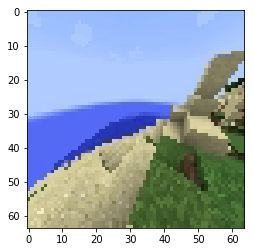

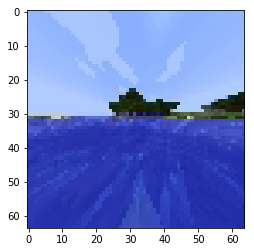

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


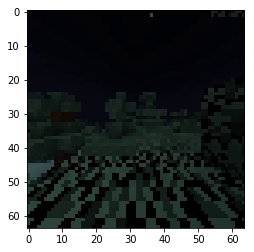

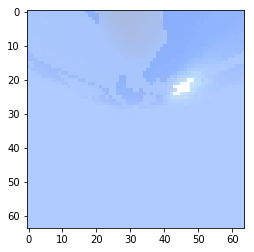

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


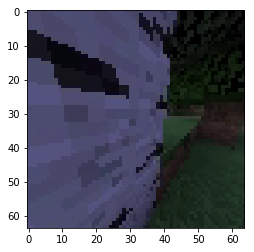

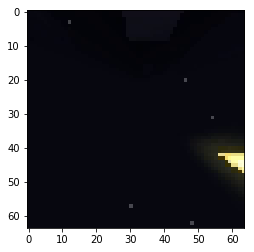

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  9
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '0']


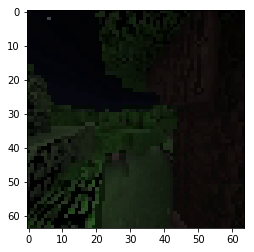

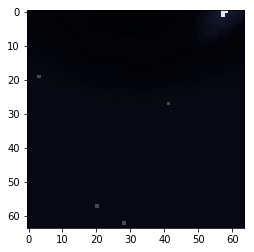

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  9
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']


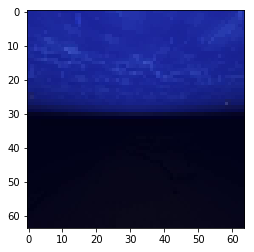

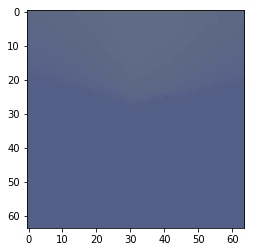

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0']


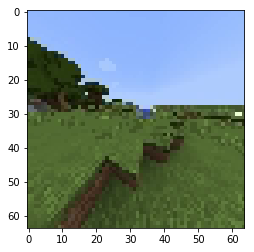

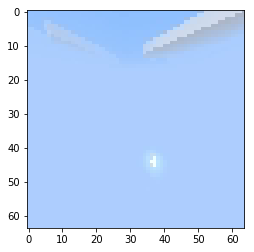

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  9
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


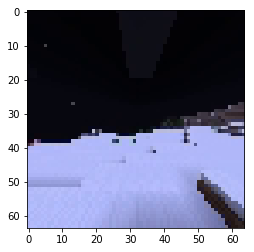

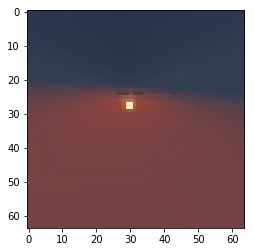

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  9
Actions:  ['1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']


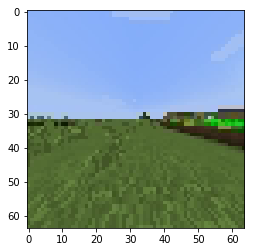

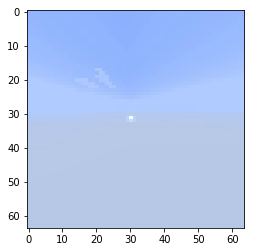

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0']


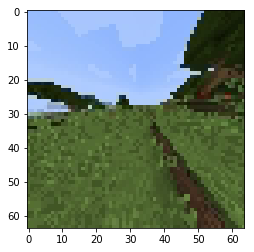

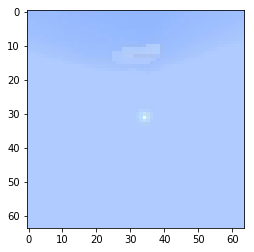

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '0' '0' '0']


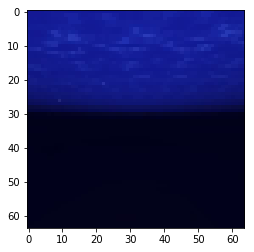

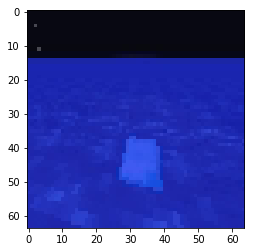

Guessed rewards:  [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Target rewards:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Best predicted action:  3
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0']


In [184]:
for i in range(10):    
    video, actions, compass_angle, rewards = generate_random_video(path)

    batch = np.random.randint(video.shape[0])
    frames = np.array(video[batch-4:batch])
    next_frames = np.array(video[batch-3:batch+1])

    plt.imshow(video[0].astype(np.uint8))
    plt.show()

    plt.imshow(video[-1].astype(np.uint8))
    plt.show()

    actions = np.array(actions[batch])
    frames = stack_frames(video, compass_angle[batch]).reshape(1, 64, 64, 5)
    n_frames = stack_frames(next_frames, compass_angle[batch+1]).reshape(1, 64, 64, 5)

    print("Guessed rewards: ", np.round(q_model(frames)))
    print("Target rewards: ", np.round(target_model(n_frames)))
    print("Best predicted action: ", np.argmax(q_model(frames)))
    print("Actions: ", actions)

In [149]:
target_model.save("target_q_model.h5")
q_model.save("q_model.h5")